# Softmax Layer

Some key points of a softmax layer

- A softmax layer transforms an $n$-dimensional vector to a $c$-dimensional vector with norm 1 and all its components between 0 and 1.Usually $c$ is the number of classes.
- A softmax has a set of weights $\bf{W}$ and a bias vector $\bf{b}$.
- The output of the softmax is a vector representing the probability of each class.

Now let us build a softmax layer that given an input vector with `n_feat` features maps it to a `n_class` dimensional vector.

http://cs231n.github.io/neural-networks-case-study/

#### Pyplot in julia

https://github.com/JuliaPy/PyPlot.jl#exported-functions

In [1]:
using DataFrames
using PyPlot
using BenchmarkTools

In [2]:
plt[:style][:use]("ggplot")

In [3]:
T = Float32
df = DataFrames.readtable("spiraldata.csv");

In [4]:
X = Array{T}(hcat(df[:x1],df[:x2]))
y = Array{Int}(df[:y]) +1;

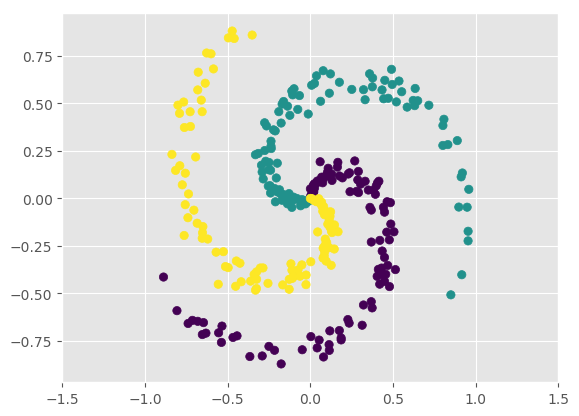

(-1.5, 1.5)

In [5]:
#PyPlot.plot(X[:,1], X[:,2],".")
PyPlot.scatter(X[:, 1], X[:, 2], c=y)
PyPlot.xlim(-1.5,1.5)

## Define Crossentropy loss and softmax layer

In [69]:
type CrossEntropyLossLayer end

In [70]:
function forward(loss::CrossEntropyLossLayer, y_prob::Vector, y::Vector)
    """
    Should this function do the onehot encoding?
    In order to save memory it seems reasonable but...
    C = number of classes
    e(t) = Encoding (as vector) of class t
          loss (h(x), e(t)) = \sum_{i=1}^{C} e(t)_i  log (h(x)_i)
    
    Returns the loss between the batch
    """
    # This breaks if Y_hat_batch contains 0 because log(0)= -Inf
    # return - sum(Y_encoded.*log.(Y_hat_batch))
    # TODO: Make it resilient to the -Inf problem: 
    # one possible solution could be take the max(0.00001, x)
    cross_entropy = 0.

    @inbounds for d in 1:length(y)
        cross_entropy +=  log(y_prob[d])
    end
    return -cross_entropy
end

forward (generic function with 2 methods)

In [71]:
#workspace()
abstract type ActivationLayer end

type SoftMaxLayer{T} <: ActivationLayer 
    """
    Standard Sotmax layer.
    The output of this layer for a given input is meant to be 
        
        output_k = e^(W*X + b)_k /sum_j (W*X + b)_j

    """
    input_dim::Int
    output_dim::Int
    W::Array{T}
    b::Vector{T}
    seed::Int
end

function SoftMaxLayer{T}(input_dim, output_dim; seed=1234) where T<:Real
    srand(seed)
    return SoftMaxLayer{T}(input_dim,
                        output_dim,
                        randn(T, output_dim, input_dim)/sqrt(input_dim),
                        zeros(output_dim),
                        seed)
end

Base.show(io::IO, l::SoftMaxLayer{T}) where T <: Number = \,
print(io,"SoftMaxLayer{$T} [input_dim: $(l.input_dim), ouput_dim: $(l.output_dim)]")

In [72]:
input_dim = 2
output_dim = 3

softmax = SoftMaxLayer{Float32}(input_dim, output_dim)

SoftMaxLayer{Float32} [input_dim: 2, ouput_dim: 3]

    #workspace()
    abstract type ActivationLayer end

    type SoftMaxLayer{T} <: ActivationLayer 
        """
        Standard Sotmax layer.
        The output of this layer for a given input is meant to be 

            output_k = e^(W*X + b)_k /sum_j (W*X + b)_j
        """
        input_dim::Int
        output_dim::Int
        W::Array{T}
        b::Vector{T}
        seed::Int
    end

    function SoftMaxLayer{T}(input_dim, output_dim; seed=1234) where T<:Number 
        srand(seed)
        return SoftMaxLayer(input_dim,
                            output_dim,
                            randn(T, output_dim, input_dim)/sqrt(input_dim),
                            zeros(output_dim),
                            seed)
    end

    Base.show(io::IO, l::SoftMaxLayer{T}) where T <: Number = \,
    print(io,"SoftMaxLayer{$T} [input_dim: $(l.input_dim), ouput_dim: $(l.output_dim)]")

    input_dim = 2
    output_dim = 3

    softmax = SoftMaxLayer{Float32}(input_dim, output_dim)

### Propagate information through the softmax

In [73]:
# Elements in the batch must be column vectors
X_batch = X[1:10,:]'

2×10 Array{Float32,2}:
 0.0  0.00121358  0.00551604  0.0163369  …  0.0176683  0.0240802  0.0391946
 0.0  0.0100278   0.0194344   0.0255221     0.068464   0.0771368  0.0820259

In [74]:
function forward(softmax_layer::SoftMaxLayer, Xbatch::Array)
    """
    Layer shrinking the output to [0,1] values.
    Notice that sum(exp(Xbatch),1) will generate a Matrix with as many elements as
    columns in Xbatch. 
    """
    Xbatch_out = exp.(softmax_layer.W * Xbatch .+ softmax_layer.b)
    return Xbatch_out./sum(Xbatch_out, 1)  # Generating an array here every call
end

forward (generic function with 2 methods)

In [75]:
function forward2(softmax_layer::SoftMaxLayer, Xbatch::Array)
    """
    Layer shrinking the output to [0,1] values.
    """
    Xbatch_out = exp.(softmax_layer.W * Xbatch .+ softmax_layer.b)
    
    @inbounds for j in 1:size(Xbatch,2)
        Xbatch_out[:,j] .= view(Xbatch_out,:,j)./sum(view(Xbatch_out,:,j))
    end
        
    return Xbatch_out
end

forward2 (generic function with 1 method)

In [76]:
# Columns k of p_y_X_batch contains the probability of X_batch[:,k] 
# belonging to each of the different classes.
p_y_X_batch = forward(softmax, X_batch)

3×10 Array{Float32,2}:
 0.333333  0.329792  0.327253  0.327564  …  0.311657  0.30993   0.311666
 0.333333  0.333444  0.332992  0.331339     0.332075  0.331167  0.328786
 0.333333  0.336763  0.339755  0.341096     0.356268  0.358903  0.359549

In [77]:
forward(softmax, X_batch)

3×10 Array{Float32,2}:
 0.333333  0.329792  0.327253  0.327564  …  0.311657  0.30993   0.311666
 0.333333  0.333444  0.332992  0.331339     0.332075  0.331167  0.328786
 0.333333  0.336763  0.339755  0.341096     0.356268  0.358903  0.359549

In [78]:
forward2(softmax, X_batch)

3×10 Array{Float32,2}:
 0.333333  0.329792  0.327253  0.327564  …  0.311657  0.30993   0.311666
 0.333333  0.333444  0.332992  0.331339     0.332075  0.331167  0.328786
 0.333333  0.336763  0.339755  0.341096     0.356268  0.358903  0.359549

In [79]:
@benchmark forward(softmax, X_batch)

BenchmarkTools.Trial: 
  memory estimate:  752 bytes
  allocs estimate:  4
  --------------
  minimum time:     768.829 ns (0.00% GC)
  median time:      799.293 ns (0.00% GC)
  mean time:        884.193 ns (4.63% GC)
  maximum time:     17.622 μs (90.09% GC)
  --------------
  samples:          10000
  evals/sample:     111

In [80]:
@benchmark forward2(softmax, X_batch)

BenchmarkTools.Trial: 
  memory estimate:  896 bytes
  allocs estimate:  12
  --------------
  minimum time:     870.071 ns (0.00% GC)
  median time:      898.125 ns (0.00% GC)
  mean time:        999.261 ns (6.17% GC)
  maximum time:     38.098 μs (92.18% GC)
  --------------
  samples:          10000
  evals/sample:     56

#### Predict the class of every element in a minibatch

In [81]:
"""
    Function to predict the class labels for a given batch of class probabilities.
    The probabilities for each class should be organized in columns.
    Therefore 
        - the number of rows in Xprobs must be the number of classes
        - the number of columns in Xprobs must be the number of elements in the batch
"""
function predict_class(Xprobs::Array)
    
    predicted_classes = zeros(Int, size(Xprobs,2))
    
    @inbounds for i in 1:size(Xprobs, 2)
        predicted_classes[i] = indmax(view(Xprobs,:,i))
    end
    return predicted_classes
end

predict_class

In [82]:
X_probs = forward(softmax, X_batch)

3×10 Array{Float32,2}:
 0.333333  0.329792  0.327253  0.327564  …  0.311657  0.30993   0.311666
 0.333333  0.333444  0.332992  0.331339     0.332075  0.331167  0.328786
 0.333333  0.336763  0.339755  0.341096     0.356268  0.358903  0.359549

In [83]:
@benchmark predict_class(X_probs)

BenchmarkTools.Trial: 
  memory estimate:  640 bytes
  allocs estimate:  11
  --------------
  minimum time:     232.442 ns (0.00% GC)
  median time:      248.909 ns (0.00% GC)
  mean time:        312.895 ns (14.65% GC)
  maximum time:     9.403 μs (90.47% GC)
  --------------
  samples:          10000
  evals/sample:     464

#### Crossentropy loss

In [84]:
function crossentropyloss(y, y_pred)
    batch_size = length(y)
    ce = zero(eltype(y_pred))
    
    @inbounds for k in batch_size
        ce += -log(y_pred[y[k],k])
    end
    return ce/batch_size
end

crossentropyloss (generic function with 1 method)

In [85]:
y_pred = forward(softmax, X_batch)
ce = crossentropyloss(y[1:10], y_pred)
ce

0.116582476f0

In [86]:
@benchmark crossentropyloss(y[1:10], y_pred)

BenchmarkTools.Trial: 
  memory estimate:  208 bytes
  allocs estimate:  3
  --------------
  minimum time:     145.837 ns (0.00% GC)
  median time:      157.749 ns (0.00% GC)
  mean time:        184.430 ns (11.44% GC)
  maximum time:     5.171 μs (91.38% GC)
  --------------
  samples:          10000
  evals/sample:     852

#### Compute the gradient of the softmax

In [87]:
function grad(softmax::SoftMaxLayer, Xbatch, y)
    
    y_pred = forward(softmax, Xbatch)
    ce = crossentropyloss(y, y_pred)
    scores = copy(y_pred)
    
    @inbounds for k in y
        scores[y[k],k] -= 1
    end
    
    scores .= scores/length(y)
    grad_W =  scores * Xbatch'
    grad_b = sum(scores, 2)[:]
    
    return grad_W, grad_b, ce
end

grad (generic function with 1 method)

In [88]:
size(X_batch), size(y[1:10])

((2, 10), (10,))

In [89]:
grad_W, grad_b, ce = grad(softmax, X_batch, y[1:10])

(Float32[0.00476351 0.0133535; 0.00497069 0.0140109; 0.00530026 0.0149254], Float32[-0.679091, 0.331916, 0.347175], 0.116582476f0)

In [90]:
Xb = X[1:5,:]'
yb = y[1:5]

grad_W, grad_b, ce = grad(softmax, Xb, yb)

(Float32[0.00285095 0.00586512; 0.00289437 0.00595428; 0.00298881 0.00612861], Float32[-0.671395, 0.332396, 0.338999], 0.2247366f0)

### Train the softmax using SGD

In [91]:
mod(20,10)

0

In [92]:
input_dim = 2
output_dim = 3
softmax = SoftMaxLayer{Float32}(input_dim, output_dim)

learning_rate = 0.01
batch_size = 20
averaged_loss = 0
print_every_k = 50

for i in 1:500
    averaged_loss = 0
    for j in 1:batch_size:(length(y)-batch_size)
        grad_W, grad_b, ce = grad(softmax, X[j:j+batch_size,:]', y[j:j+batch_size])
        softmax.W -= learning_rate * grad_W
        softmax.b -= learning_rate * grad_b
        averaged_loss += ce
    end
    averaged_loss += ce
    if mod(i, print_every_k) == 0
        println("loss: ",  averaged_loss)
    end
end

loss: 0.6668119
loss: 0.6143365
loss: 0.5858017
loss: 0.5693011
loss: 0.55924326
loss: 0.55291957
loss: 0.5489052
loss: 0.54638827
loss: 0.5448758
loss: 0.54405254


In [93]:
## Accuracy in the whole train set
Xprob = forward(softmax, X')
acc = sum(predict_class(Xprob) .== y) /length(y)
println(acc)

0.58


#### Plotting the decision boundary

    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    #fig.savefig('spiral_linear.png')

In [94]:
xx = linspace(-1,1, 200)

-1.0:0.010050251256281407:1.0

In [95]:
n = 10

a = linspace(Int(floor(minimum(X[:,1]))), floor(maximum(X[:,1])+1))
b = linspace(Int(floor(minimum(X[:,2]))), floor(maximum(X[:,2])+1))

grid_a = vec(broadcast((x,y) -> x, a, b'))
grid_b = vec(broadcast((x,y) -> y, a, b'));

In [96]:
X = Array{T}(hcat(df[:x1],df[:x2]))
y = Array{Int}(df[:y]) +1;

In [97]:
Xgrid = hcat(grid_a,grid_b);

In [98]:
ygrid = predict_class(forward(softmax, Xgrid'));

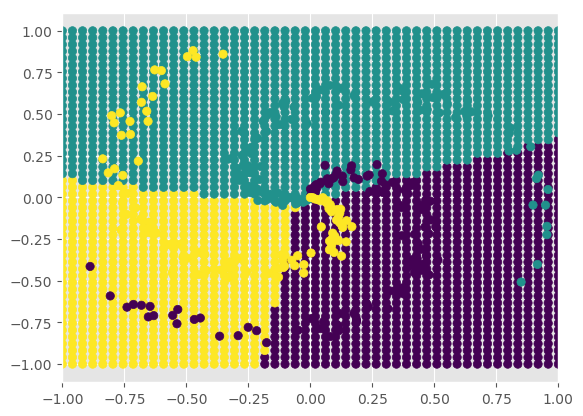

(-1.0, 1.0)

In [99]:
PyPlot.scatter(grid_a, grid_b, c=ygrid)
PyPlot.scatter(X[:, 1], X[:, 2], c=y)
PyPlot.xlim(-1., 1.)

In [100]:
yprobgrid = forward(softmax, Xgrid')

3×2500 Array{Float32,2}:
 0.117798    0.128697    0.140443    …  0.0411389   0.0440779  0.0472163 
 0.00742086  0.00754489  0.00766219     0.953588    0.950816   0.94784   
 0.874781    0.863758    0.851895       0.00527292  0.005106   0.00494326

In [101]:
size(grid_a), size(grid_b), size(yprobgrid[1,:])

((2500,), (2500,), (2500,))

In [138]:
#plt[:contourf](grid_a, grid_b, yprobgrid, cmap)
#PyPlot.scatter(X[:, 1], X[:, 2], c=ygrid)
#PyPlot.xlim(-1., 1.)

### Plot regions

We can make a prettier plot of the class regions using `contourf`:

Example of `contourf`

https://github.com/cstjean/ScikitLearn.jl/blob/master/examples/Two_Class_Adaboost.ipynb

                  
How to make the contourf:
```
x_min, x_max = minimum(X[:, 1]) - 1, maximum(X[:, 1]) + 1
y_min, y_max = minimum(X[:, 2]) - 1, maximum(X[:, 2]) + 1
xx, yy = meshgrid(x_min:plot_step:x_max, y_min:plot_step:y_max)

Z = predict(bdt, hcat(xx[:], yy[:]));
Z = reshape(Z, size(xx)...);

cs = contourf(xx, yy, Z, cmap=get_cmap("Paired"))
plt[:axis]("tight")
```


#### Example plotting probability

https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression

http://julia-programming-language.2336112.n4.nabble.com/plt-contourf-equivalent-in-PyPlot-jl-td33116.html

http://www.python-course.eu/matplotlib_contour_plot.php

In [123]:
cmap = get_cmap("Blues_r")

In [126]:
contourf

contourf (generic function with 2 methods)

In [127]:
xlist = [x for x in linspace(-3,3,100)];
ylist = [x for x in linspace(-3,3,100)];

Z = sqrt.(xlist.^2 .+ ylist.^2);

In [128]:
X = reshape(xlist,100,1)
Y = reshape(ylist,100,1);
Z = reshape(Z,100,1);

In [132]:
plt[:contourf]

PyObject <function contourf at 0x134ce35f0>

In [133]:
#plt[:contourf](grid_a, grid_b, y_pred,cmap=get_cmap("Spectral"), alpha=0.8) 

In [134]:
#plt[:contourf](X[:,1],X[:,2],y, cmap)

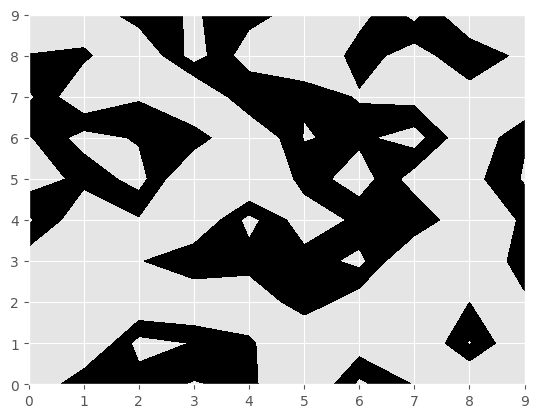

size of R: (10, 10)


PyObject <matplotlib.contour.QuadContourSet object at 0x127fce690>

In [8]:
R = rand(-10:0.1:10, (10,10))
println("size of R: ", size(R))
contourf(R, [0.0,6], colors=("k"))

In [9]:
#cs = plt[:contourf](grid_a, grad_b, Z, cmap=get_cmap("Paired"))

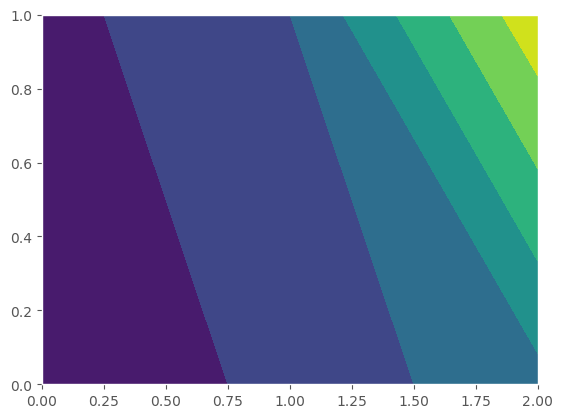

PyObject <matplotlib.contour.QuadContourSet object at 0x1280a55d0>

In [10]:
plt[:contourf]([[0,2,4],[1,3,10]])

In [117]:
#contourf(Xgrid[:,1], Xgrid[:,2],y)

#### make prettier plot

In [118]:
plt[:contourf]

PyObject <function contourf at 0x134ce35f0>

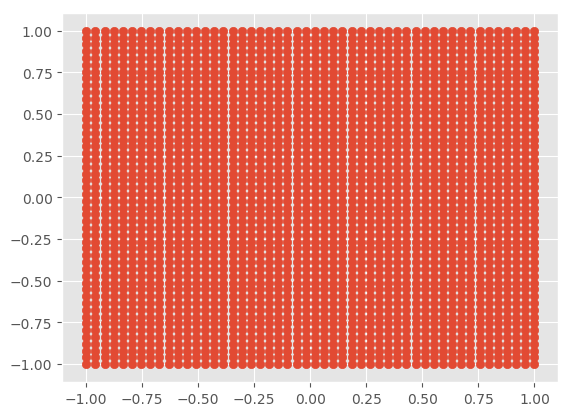

PyObject <matplotlib.collections.PathCollection object at 0x13d30c490>

In [119]:
PyPlot.scatter(Xgrid[:,1], Xgrid[:,2])

In [266]:
# contourf(grid_a, grid_b, c=ygrid)

In [ ]:
PyPlot.cm[:Blues]
PyPlot.cm[:Reds]
PyPlot.cm[:RdGy]
PyPlot.cm[:YlGn]